# Pacotes

In [36]:

# Conection Data
from google.cloud import bigquery # conexão banco de dados
from google.oauth2 import service_account # conexão banco de dados
from pandas.io import gbq # conexão banco de dados

# Tratament Data
import pandas as pd  # biblioteca para trabalhar com dataframes e realizar ETL
import numpy as np  # biblioteca para trabalhar com arrays
import statsmodels.api as sm  # biblioteca para explorar, estimar e testar dados e modelos estatísticos 
import matplotlib.pyplot as plt  #biblioteca para criar gráficos "comuns" ao estilo Matlab.
from datetime import date, timedelta, datetime  # biblioteca para trabalhar com datas
from dateutil.relativedelta import relativedelta  # biblioteca de extensão do datetime
from scipy import stats  # biblioteca de computação científica
from pandas import DataFrame 

# Tratament Models
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models Machine Learnig
from sklearn.linear_model import LogisticRegression  # Regressão Logit do sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics Models
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

# Pipeline Model
from sklearn.pipeline import Pipeline, make_pipeline

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

# Load Dataset

In [2]:
# Credenciais Google Cloud

credentials = service_account.Credentials.from_service_account_file(filename='/home/alex/apps/crendentials/ContaServicoBigQuery.json', 
                                                                    scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(credentials=credentials)
# Query SQL
sql = """
SELECT
  CASE
    WHEN ra.nota < 4 THEN "Negativo"
    WHEN ra.nota  >= 7 THEN "Positivo"
    END AS sentimento,
  ra.tempo_reclamacao,
  ra.status,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Sinistro|sinistro|Sinitros|sinistros|Carro|carro|Carros|Carro|Proteção|proteção|Proteções|proteções|Atendimento|atendimento|Atendimentos|atendimentos') AS token_positivo,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Prestamista|prestamista|Prestamistas|prestamistas|Sinistro|sinistro|Sinitros|sinistros|Cancelamento|cancelamento|Cancelamentos|cancelamento|Reembolso|reembolso|Reembolsos|reembolsos') AS token_negativo
FROM `braided-upgrade-355410.ReclameAquiStage.reclamacoes` as ra
WHERE ra.nota > 7 OR ra.nota < 4 
"""


In [3]:
# carrega dataset
dataset = client.query(sql).to_dataframe()

In [4]:
# copy

df = dataset.copy()

In [5]:
# verificando o dataset

df.head()

,sentimento,tempo_reclamacao,status,token_positivo,token_negativo
0,Negativo,4,Não resolvido,False,False
1,Negativo,13,Não resolvido,False,True
2,Negativo,15,Não resolvido,True,True
3,Negativo,15,Não resolvido,False,False
4,Negativo,16,Resolvido,False,False


In [6]:
print('Amostras e Features', df.shape)
print('Columns: ', df.dtypes)

Amostras e Features (1418, 5)
Columns:  sentimento           object
tempo_reclamacao      Int64
status               object
token_positivo      boolean
token_negativo      boolean
dtype: object


# Removendo Outliers

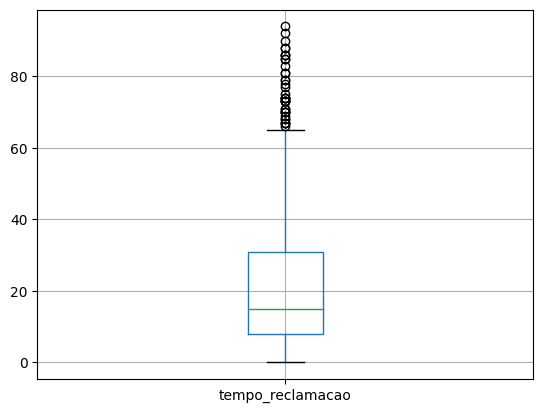

In [7]:
#verificando se existem outliers (anomalias) usando o boxblot

boxplot = df.boxplot(column=['tempo_reclamacao'])

In [8]:
def remove_outliers(columns: list, qtd_desvios: int, df: DataFrame) -> DataFrame:
    
    for column in columns:
        
        quartil_01 = df[column].quantile(q=0.25)
        quartil_03 = df[column].quantile(q=0.75)
        amplitude = quartil_03 - quartil_01
        
        print(f'''
        Coluna: {column}
        Tamanho Inicial: {df.shape[0]}
        ''')
        
        # df = df.loc[~df.index.isin(list(result[0]))]
        
        df = df.loc[
            (df[column] > (quartil_01 - 1.5 * amplitude)) &
            (df[column] < (quartil_03 + 1.5 * amplitude))
        ]
        
        print(f'''
        Tamanho Final: {df.shape[0]}
        ##########################################
        ''')
        
    return df

In [9]:
df2 = remove_outliers(['tempo_reclamacao'], 1, df)


        Coluna: tempo_reclamacao
        Tamanho Inicial: 1418
        

        Tamanho Final: 1379
        ##########################################
        


# Dummies

Para a transformão iremos utilizar dois metódos:

dummy: transformar uma variavel categorica com valores 0 e 1.

combinação de recursos: na combinação de recursos pegaremos duas variavies categóricas semelhante e combinaremos em uma única variável.


In [10]:
df3 = df2.copy()

In [11]:
df3['sentimento'].replace({'Positivo':'1',
                            'Negativo':'0'},inplace=True)

In [12]:
df3.groupby(by=['sentimento']).count()

,tempo_reclamacao,status,token_positivo,token_negativo
sentimento,,,,
0,967,967,967,967
1,412,412,412,412


In [13]:
df3['sentimento'] = df3['sentimento'].astype(int)

In [14]:
df3['status'].replace({'Resolvido':'1',
                            'Não resolvido':'0'},inplace=True)

In [15]:
df3.groupby(by=['status']).count()

,sentimento,tempo_reclamacao,token_positivo,token_negativo
status,,,,
0,679,679,679,679
1,700,700,700,700


In [16]:
df3['status'] = df3['status'].astype(int)

# Analisando a multicolinearidade

In [17]:
df3.dtypes

sentimento            int64
tempo_reclamacao      Int64
status                int64
token_positivo      boolean
token_negativo      boolean
dtype: object

In [18]:
# verificando multicolinearidade
# VIF 
vif_df = pd.DataFrame() 
vif_df['var'] = df3.columns

# Calculando o VIF para cada variável

vif_df["VIF"] = [variance_inflation_factor(np.array(df3.values, dtype=float), i) 
                          for i in range(len(df3.columns))] 

print(vif_df)

                var       VIF
0        sentimento  2.389501
1  tempo_reclamacao  1.646036
2            status  2.974743
3    token_positivo  2.724090
4    token_negativo  2.754431


In [19]:
df4 = df3.copy()

# Correlação

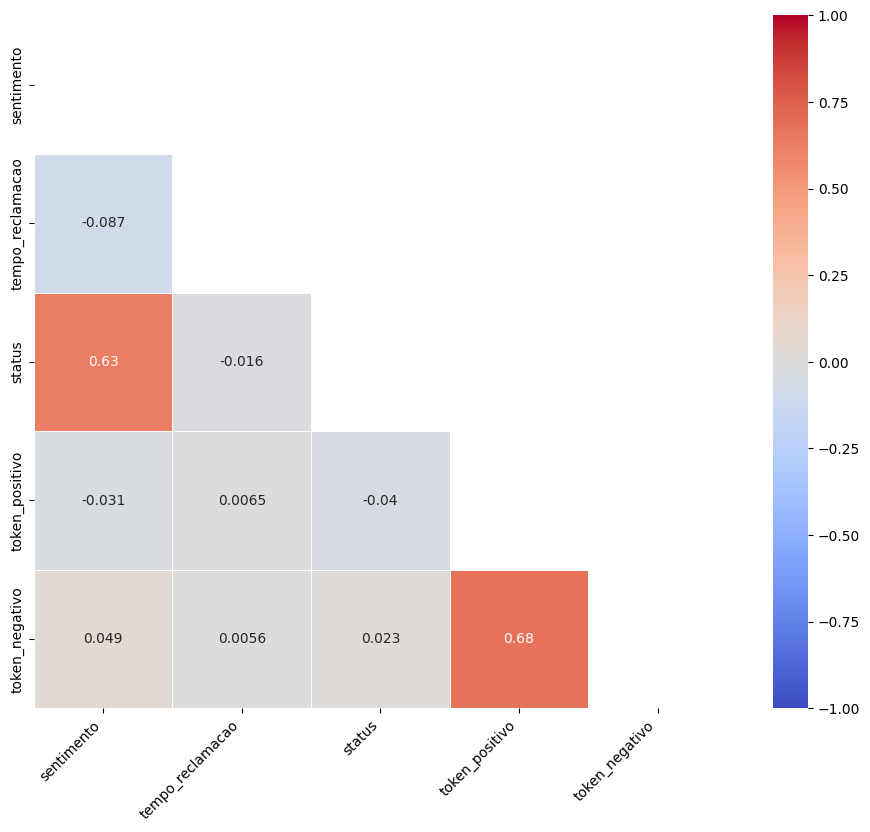

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,9))
corr = df4.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    mask = mask,
    linewidths=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

# Splitting the dataset into the Training set and Test set

In [23]:
# separando os dados em treino e teste
X = df4.loc[:, df4.columns != 'sentimento']
y = df4.loc[:, df4.columns == 'sentimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# salvando as variaveis xn
columns = X_train.columns

In [24]:
X_train = X_train.astype(int, errors='ignore')

In [25]:
X_train.head()

,tempo_reclamacao,status,token_positivo,token_negativo
611,17,0,0,1
447,43,0,0,0
964,58,0,1,1
338,4,1,0,0
1401,44,1,0,0


In [26]:
y_train =  y_train.astype(int, errors='ignore')

In [27]:
y_train.head()

,sentimento
611,0
447,0
964,0
338,0
1401,1


# Feature Scaling - Padronização de Valores

Utilizamos a padronização de valores quando temos valores muitos descrepetantes. Desta forma, os valores são transformados em um intervalo de -3 a 3.

*Obs*: caso os valores já estiveram no intervalo de -3 a 3 não será necessário padronizalos.

In [28]:
dados_num = X_train.loc[:,['tempo_reclamacao']]
scraler = StandardScaler()
X_train['tempo_reclamacao'] = StandardScaler().fit_transform(dados_num)

In [29]:
X_train.head()

,tempo_reclamacao,status,token_positivo,token_negativo
611,-0.188394,0,0,1
447,1.536665,0,0,0
964,2.531891,0,1,1
338,-1.050923,1,0,0
1401,1.603013,1,0,0


# Balanceamento

In [30]:
# Aplicando o metodo SMOTE
os = SMOTE(random_state=0)

# modelando em cima dos dados de treino
os_data_X,os_data_y= os.fit_resample(X_train, y_train)

In [31]:
print("Tamanho da Amostra final: ",len(os_data_X))
print("Quantidade de sentimentos negativos", len(os_data_y[os_data_y['sentimento']==0]))
print("Quantidade de sentimentos positivos", len(os_data_y[os_data_y['sentimento']==1]))
print("Proporcao de sentimentos negativos",len(os_data_y[os_data_y['sentimento']==0])/len(os_data_X))
print("Proporcao de sentimentos positivos",len(os_data_y[os_data_y['sentimento']==1])/len(os_data_X))

Tamanho da Amostra final:  1408
Quantidade de sentimentos negativos 704
Quantidade de sentimentos positivos 704
Proporcao de sentimentos negativos 0.5
Proporcao de sentimentos positivos 0.5


# Train - Model 1

## Regressao Logit

In [33]:
# setando as variaveis dependentes
X=os_data_X[columns];

# setando a variavel resposta
y=os_data_y['sentimento'];

In [34]:
# aplicando o modelo nos dados de treino

logit_model = sm.Logit(y,X)

# treinando o modelo

result = logit_model.fit()

# Printando os resultados

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.558178
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.195     
Dependent Variable: sentimento       AIC:              1579.8300 
Date:               2023-01-09 23:01 BIC:              1600.8297 
No. Observations:   1408             Log-Likelihood:   -785.91   
Df Model:           3                LL-Null:          -975.95   
Df Residuals:       1404             LLR p-value:      4.5848e-82
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
tempo_reclamacao  -0.2040   0.0616 -3.3132 0.0009 -0.3247 -0.0833
status             1.6667   0.1010 16.5037 0.0000  1.4688  1.8647


In [35]:
# Aplicando o modelo usando o sklearn

logreg = LogisticRegression(random_state=0)
logreg.fit(X, y)

LogisticRegression(random_state=0)

In [36]:
y_pred = logreg.predict(X_test)

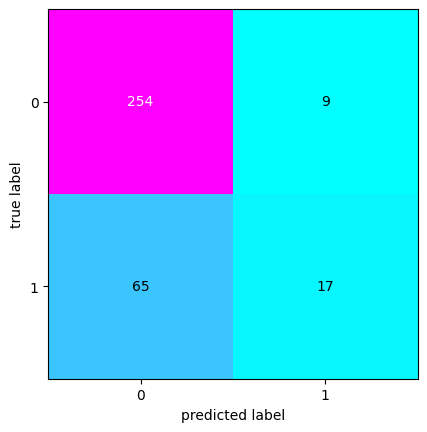

In [38]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

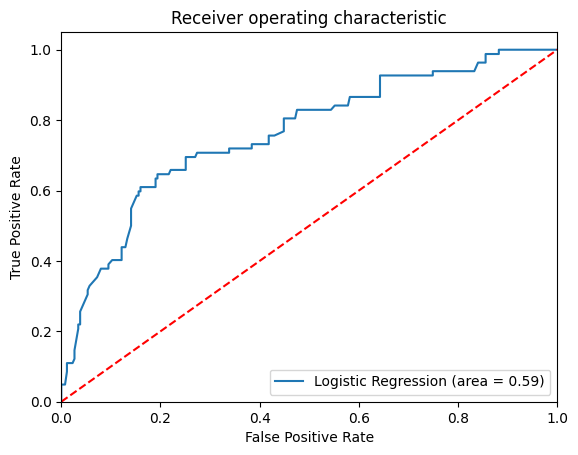

In [39]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [40]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.6538461538461539

Recall
 0.2073170731707317

F1
 0.3148148148148148

AUCROC
 0.58654827042567


### Grid Search

In [33]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
#
# Create the parameter grid
#
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the LogisticRegression Classifier
#
gsLR = gsLR.fit(X_train, y_train.values.ravel())
#
# Print the training score of the best model
#
print("score of the best model: ", gsLR.best_score_)
#
# Print the model parameters of the best model
#
print(" model parameters of the best model",gsLR.best_params_)
#
# Print the test score of the best model
#
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

score of the best model:  0.791168782673637
 model parameters of the best model {'logisticregression__C': 10.0}
Test accuracy: 0.771


## SVM

In [43]:
from sklearn.svm import SVC
svmreg = SVC(kernel='rbf',probability=True)
svmreg.fit(X, y);

In [44]:
y_pred = svmreg.predict(X_test)

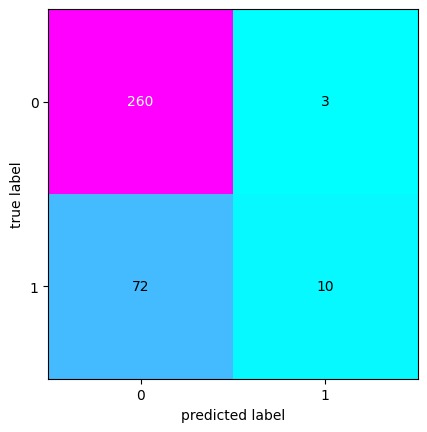

In [45]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

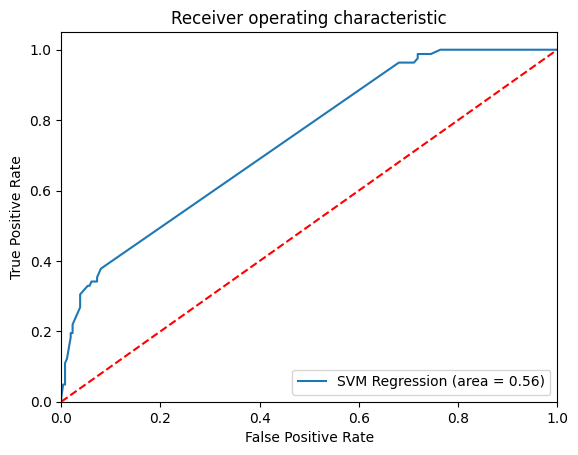

In [46]:
logit_roc_auc = roc_auc_score(y_test, svmreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svmreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [47]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.7692307692307693

Recall
 0.12195121951219512

F1
 0.2105263157894737

AUCROC
 0.5552721877028657


### Grid Search

In [48]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
#
# Create the parameter grid
#
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear']
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the SVM classifier
#
gsSVC.fit(X_train, y_train.values.ravel())
#
# Print the training score of the best model
#
print('Training score of the best model: ', gsSVC.best_score_)
#
# Print the model parameters of the best model
#
print('Model parameters of the best model: ', gsSVC.best_params_)
#
# Print the model score on the test data using GridSearchCV score method
#
print('Model score on the test data using GridSearchCV score method: %.3f' % gsSVC.score(X_test, y_test))
#
# Print the model score on the test data using Best estimator instance
#
clfSVC = gsSVC.best_estimator_
print('Model score on the test data using Best estimator instance: %.3f' % clfSVC.score(X_test, y_test))

NameError: name 'make_pipeline' is not defined

## KNN

In [49]:
# Aplicando o modelo usando o sklearn
from sklearn.neighbors import KNeighborsClassifier

knnreg = KNeighborsClassifier();
knnreg.fit(X, y);

In [50]:
y_pred = knnreg.predict(X_test)
print('Accuracy of knn regression classifier on test set: {:.2f}'.format(knnreg.score(X_test, y_test)))

Accuracy of knn regression classifier on test set: 0.78


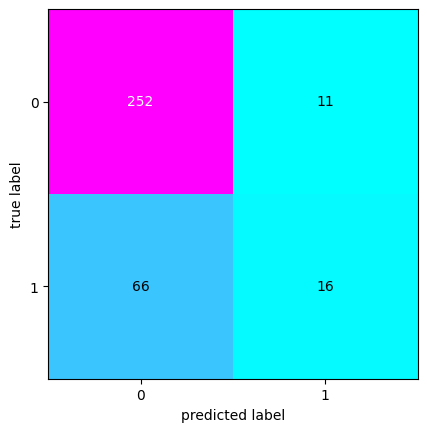

In [51]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

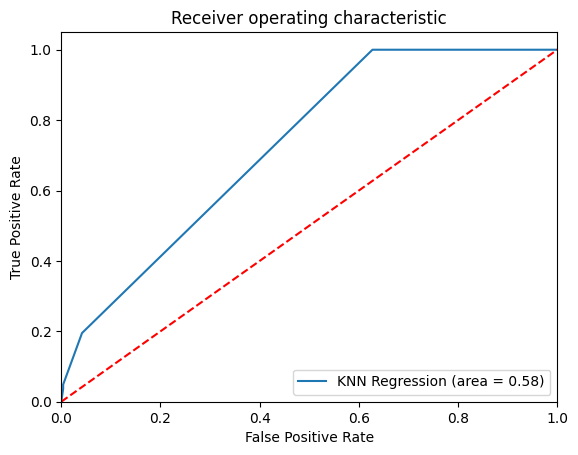

In [52]:
logit_roc_auc = roc_auc_score(y_test, knnreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knnreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [53]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5925925925925926

Recall
 0.1951219512195122

F1
 0.29357798165137616

AUCROC
 0.576648428081239


### Grid Search

In [54]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn,
                    param_grid,
                    cv = 10, 
                    scoring = 'accuracy',
                    n_jobs=-1)
grid.fit(X,y)

#print(grid.grid_scores_)
'''
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)
'''

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8451671732522795
{'n_neighbors': 21, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=21)


## Random Forest Classifiers


In [93]:
from sklearn.ensemble import RandomForestClassifier
rfreg = RandomForestClassifier(n_estimators= 10, random_state=42)
rfreg.fit(X, y);

In [67]:
y_pred = rfreg.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.4f}'.format(rfreg.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.7652


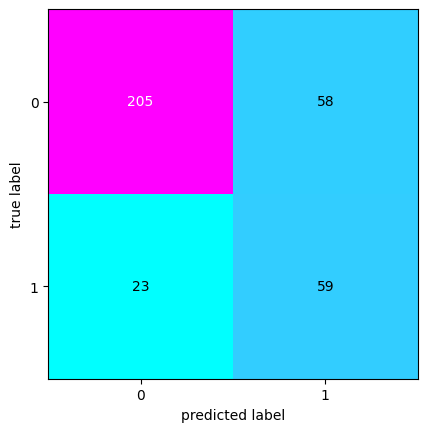

In [68]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

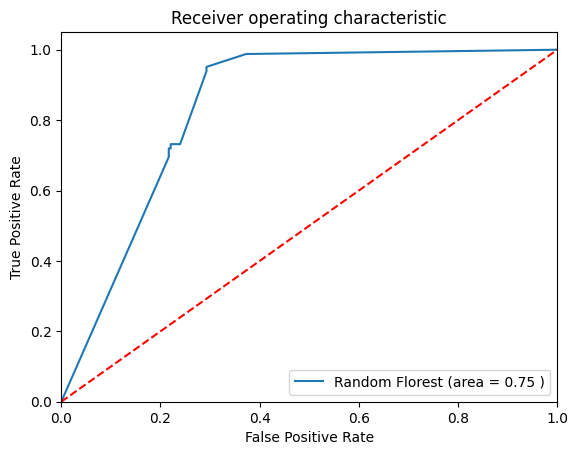

In [69]:
logit_roc_auc = roc_auc_score(y_test, rfreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [70]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5042735042735043

Recall
 0.7195121951219512

F1
 0.5929648241206029

AUCROC
 0.749489937865158


### Gread Search

In [95]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))
#
# Create the parameter grid
#
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
#
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='f1',
                     cv=10,
                     refit=True,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC = gsRFC.fit(X_train, y_train.values.ravel())
#
# Print the training score of the best model
#
print(gsRFC.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

ValueError: Invalid parameter 'randomforestclassifier' for estimator RandomForestClassifier(random_state=1). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

## Decision Tree Classifiers


In [83]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [84]:
y_pred = classifier.predict(X_test)

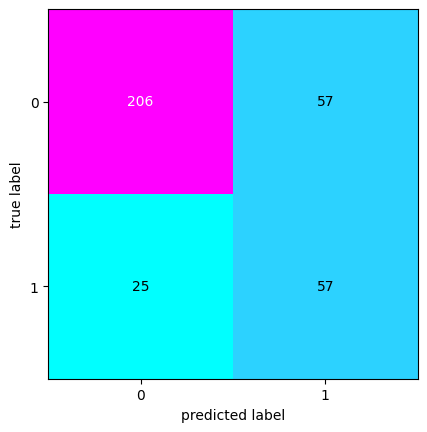

In [85]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

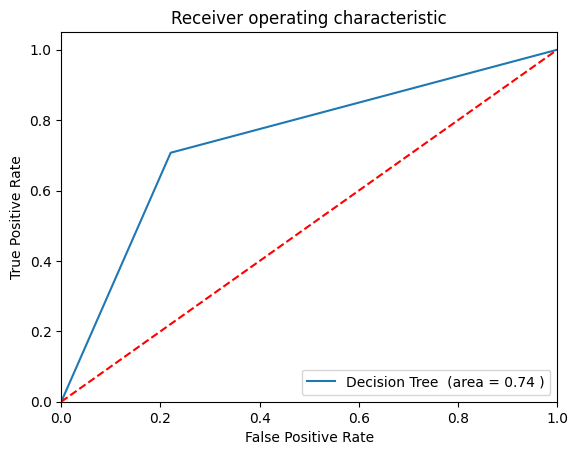

In [86]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree  (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [87]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5

Recall
 0.6951219512195121

F1
 0.5816326530612245

AUCROC
 0.7391959565983492


### Gread Search 

In [88]:
param_dict = {
    "criterion":['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_leaf":range(1,5)}

In [89]:
gsRFC = GridSearchCV(estimator=DecisionTreeClassifier(),
                     param_grid = param_dict,
                     scoring='f1',
                     cv=10,
                     verbose=1,
                     n_jobs=1)
#
# Train the RandomForestClassifier
#
gsRFC = gsRFC.fit(X_train, y_train.values.ravel())
#
# Print the training score of the best model
#
print(gsRFC.best_score_)
#
# Print the model parameters of the best model
#
print(gsRFC.best_params_)
#
# Print the test score of the best model
#
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0.7549983050668582
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
Test accuracy: 0.759


In [90]:
y_pred = gsRFC.predict(X_test)

In [91]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.49693251533742333

Recall
 0.9878048780487805

F1
 0.6612244897959184

AUCROC
 0.8380089029027172


## XGBOOST


In [55]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [56]:
y_pred = classifier.predict(X_test)

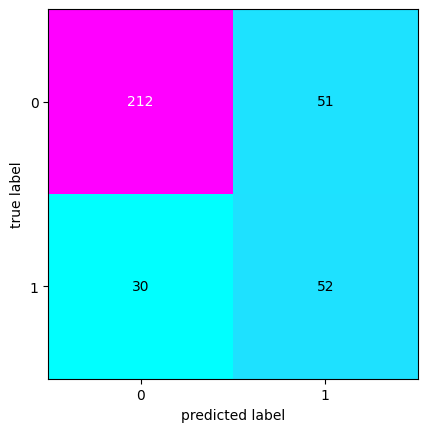

In [57]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

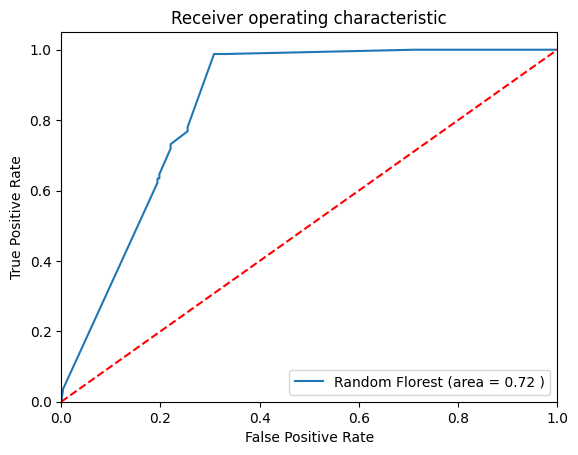

In [58]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [59]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5048543689320388

Recall
 0.6341463414634146

F1
 0.5621621621621622

AUCROC
 0.7201149958267644


### Grid Search

In [74]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [75]:
# Define grid search
grid_search = GridSearchCV(estimator=XGBClassifier(), 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='f1', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.7447
The best hyperparameters are {'colsample_bytree': 0.3, 'reg_alpha': 5, 'reg_lambda': 0}


In [76]:
y_pred = grid_search.predict(X_test)

In [77]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.49056603773584906

Recall
 0.9512195121951219

F1
 0.6473029045643154

AUCROC
 0.8216173606602986
